In [1]:
import numpy as np
import shap
import torch
from D3QN import D3QN
from run import generate_observation,ACTIONS
from simulator import env

feature_names = None
obs_dim = 22
action_len = 7
agent = D3QN(alpha=0.0003, state_dim=obs_dim, action_dim=action_len,
             fc1_dim=256, fc2_dim=256, ckpt_dir="./models", gamma=0.99, tau=0.005, epsilon=1.0,
             eps_end=0.05, eps_dec=5e-4, max_size=1000000, batch_size=64)
x, y = [], []

8 edge servers created!
生成用户中 |████████████████████████████████████████| 100/100 [100%] in 0.0s (3941.37/s) 
100 users created!
生成服务中 |████████████████████████████████████████| 10000/10000 [100%] in 2.1s (4845.56/s) 
10000 services created!
Loading Q_eval network successfully!
Loading Q_target network successfully!
Loading Q_eval network successfully!
Loading Q_target network successfully!


In [2]:
def request_callback(conn):
    global feature_names
    obs_ = generate_observation(env, conn)
    print(obs_)
    feature_names = list(obs_.keys())
    obs_ = list(obs_.values())
    x.append(np.array(obs_))
    action_index = agent.choose_action(obs_)
    y.append(action_index)


count = 0
env.request_callback = request_callback
while True:
    if count >= 10:
        break
    env.tick()
    count += 1


Timestamp: 0 Millisecond
有 100 个服务可供 <simulator.user.User object at 0x000001B1E425A7C0> 选择
【服务被选择】<simulator.service.Service object at 0x000001B1E49534C0> got selected by <simulator.user.User object at 0x000001B1E425A7C0> with favor score 213.71762367055769
<simulator.user.User object at 0x000001B1E425A7C0> is downloading <simulator.service.Service object at 0x000001B1E49534C0> (5184 MB)
<simulator.user.User object at 0x000001B1E425A7C0> 在 1 个边缘服务器的覆盖范围内
距离由进到远依次为：[(<simulator.edge.EdgeServer object at 0x000001B1E456FE50>, 16.144991441132284)]
<simulator.user.User object at 0x000001B1E425A7C0> 在以下 0 个边缘服务器的缓存中找到了 <simulator.service.Service object at 0x000001B1E49534C0>：
[]
<simulator.user.User object at 0x000001B1E425A7C0> 击穿缓存，尝试从 <simulator.edge.EdgeServer object at 0x000001B1E456FE50> 回源
【创建连接】<simulator.user.User object at 0x000001B1E425A7C0> is creating connection to <simulator.edge.EdgeServer object at 0x000001B1E456FE50>
<simulator.user.User object at 0x000001B1E425A7C0> 将 <simu

In [3]:
# load JS visualization code to notebook
shap.initjs()

In [4]:
x = np.array(x)
print(x.shape)

(101, 22)


In [5]:
torch.set_grad_enabled(True)
data = torch.from_numpy(x).float()
explainer = shap.DeepExplainer(agent.q_target, data)
masker = shap.maskers.Independent(x)
shap_values = explainer.shap_values(data)
#get Explanation object
shap_exp = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=data, feature_names=feature_names)


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


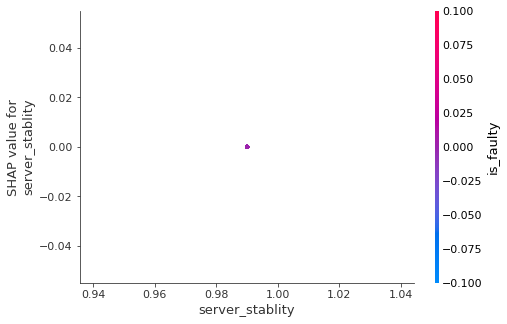

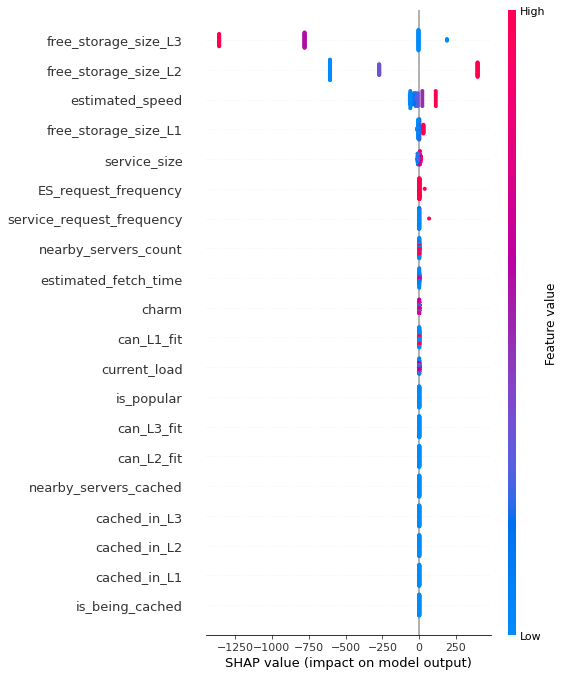

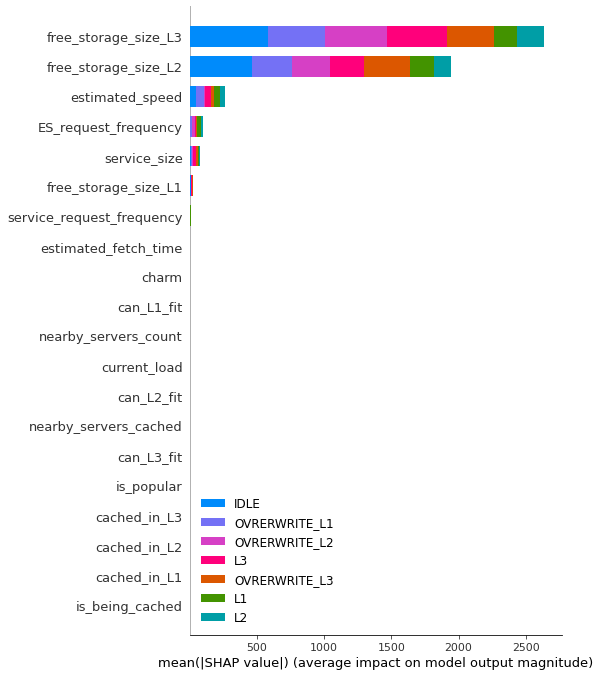

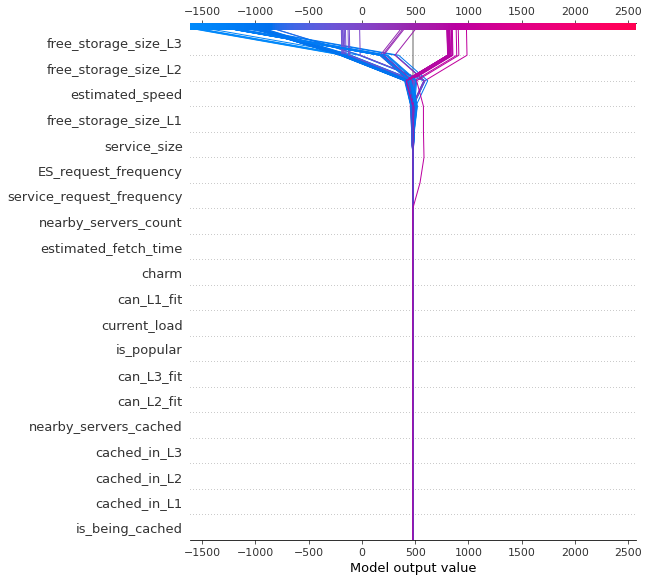

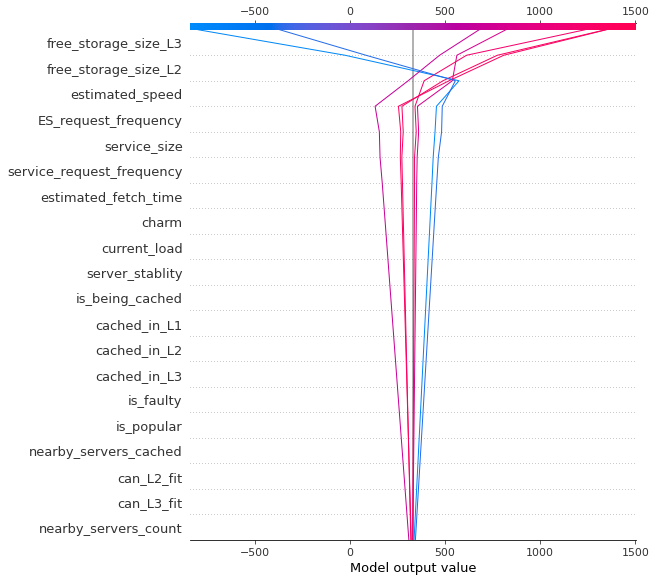

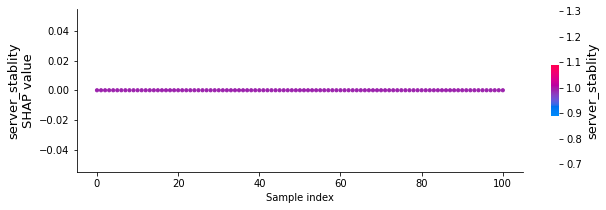

In [10]:
# Plots
class_index = 0 #第几个动作
feature_index = 1 #观测到的第几个特征
shap.dependence_plot(feature_names[feature_index], shap_values[class_index], x, feature_names, interaction_index=feature_names[0])
shap.summary_plot(shap_values[class_index], x, feature_names,class_names=ACTIONS)
shap.summary_plot(shap_values, x, feature_names,class_names=ACTIONS)
shap.decision_plot(explainer.expected_value[class_index], shap_values[class_index], feature_names)
shap.multioutput_decision_plot(list(explainer.expected_value), shap_values,row_index=feature_index,feature_names=feature_names)
shap.monitoring_plot(feature_index,shap_values[class_index],x, feature_names)

#shap.partial_dependence_plot(0, agent.q_target, data)
#shap.bar_plot(shap_values[sample_index],x,feature_names)
#shap.waterfall_plot(shap_exp)
#shap.group_difference_plot(shap_values[sample_index], x, feature_names)

shap.force_plot(explainer.expected_value[class_index], shap_values[class_index], feature_names)
#shap.force_plot(explainer.expected_value[sample_index], shap_values[sample_index][idx], masker.data[idx])